In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import random
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from sklearn.utils import shuffle

2023-11-20 18:03:17.882024: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 18:03:17.926137: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 18:03:18.122866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-20 18:03:18.122917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-20 18:03:18.156097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

**LOAD AND PREPARE DATA**

In [3]:
train_df = pd.read_csv("../data/jobfair_train.csv")

train_df["global_competition_level"].fillna(0, inplace=True)

train_df.sort_values(by="league_id", inplace=True)

train_df.reset_index(inplace=True, drop=True)

columns_to_drop = ["season", "club_id", "league_id", "registration_country", "registration_platform_specific"]
train_df.drop(columns_to_drop, axis=1, inplace=True)

encoding_map = {
    '0) NonPayer': 0,
    '1) ExPayer': 1,
    '2) Minnow': 2,
    '3) Dolphin': 3,
    '4) Whale': 4
}
train_df["dynamic_payment_segment"] = train_df["dynamic_payment_segment"].map(encoding_map)

train_df.head()

,dynamic_payment_segment,cohort_season,avg_age_top_11_players,avg_stars_top_11_players,avg_stars_top_14_players,avg_training_factor_top_11_players,days_active_last_28_days,league_match_watched_count_last_28_days,session_count_last_28_days,playtime_last_28_days,league_match_won_count_last_28_days,training_count_last_28_days,global_competition_level,tokens_spent_last_28_days,tokens_stash,rests_stash,morale_boosters_stash,league_rank
0,0,1,21,3.936582,3.678486,0.530063,3,0,14,9495533,11,24,3.0,65,21,17,59,4
1,0,1,23,3.920945,3.658000,0.552545,12,9,26,19272719,9,24,0.0,91,3,16,7,5
2,0,1,23,3.140812,3.002486,0.608834,2,0,5,1529167,0,3,0.0,9,47,42,22,12
3,0,1,23,4.512800,4.206105,0.464074,10,3,75,29267781,10,43,2.0,106,7,0,67,2
4,0,2,25,3.800861,3.584876,0.633002,0,0,0,0,6,0,0.0,0,54,26,66,8


**TRAIN/VALIDATION DATA SPLIT**
- Every league has 14 players
- Data is sorted by "*league_id"
- Every block of 14 teams represents one league
- Data is shuffled 
- Teams related to same league are still in same block of 14 teams

In [5]:
np.random.seed(42)

num_chunks = len(train_df) // 14
league_order = np.arange(num_chunks)

np.random.shuffle(league_order)

shuffled_df = pd.concat([train_df.iloc[x * 14: (x + 1) * 14] for x in league_order])
shuffled_df.reset_index(drop=True, inplace=True)

In [6]:
shuffled_df.head(14)["league_rank"]

0     13
1     12
2      9
3      5
4      1
5      2
6     14
7     11
8      8
9      6
10     7
11     4
12     3
13    10
Name: league_rank, dtype: int64

In [7]:
train_percentage = 0.8
num_train_rows = int(len(shuffled_df) * train_percentage)

num_train_chunks = num_train_rows // 14 * 14

train_df = shuffled_df.iloc[:num_train_chunks]
test_df = shuffled_df.iloc[num_train_chunks:]

X_train = train_df.drop("league_rank", axis=1)
y_train = train_df["league_rank"]

X_valid = test_df.drop("league_rank", axis=1)
y_valid = test_df["league_rank"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [8]:
X_train_scaled.shape, X_valid_scaled.shape

((44240, 17), (11074, 17))

**MODEL TRAINING**

In [9]:
# Dictionary for storing model performances (mae)
mae_scores = {}

In [10]:
def get_league_ranks(model, X, y):
    """
    Gets teams data sorted by "league_id", where every 14 rows(teams) are related to same league.
    Calculate predicted position for every team in league and sort teams
    in same league by this predictions.
    
    Returns true values sorted by model predictions:
        Example:
        [2, 1, 4, ... 12, 14] -> team with league_rank=2 is predicted as league_rank=1 etc.

    Args:
        model (ML model): Any ML model with predict method
        X (np.ndarray): Features (each 14 rows represent one league)
        y (np.array): Targets

    Returns:
        list(list(int)): Predictions for all given leagues
    """
    global_true = []

    for i in range(0, len(y), 14):
        y_pred = model.predict(X[i:i + 14])
        y_true = list(y[i:i + 14])
        results = zip(y_true, y_pred)
        sorted_results = sorted(results, key=lambda x: x[1])
        
        columns = list(zip(*sorted_results))

        true_values = columns[0]
        
        global_true.append(true_values)
        
    return global_true

In [11]:
def plot_abs_errors(trues, preds):
    """
    Gets true and predicted values and plots how common which absoulte errors are

    Args:
        trues (list): True values
        preds (list): Predictions
    """
    abs_errors = np.abs(trues - preds)
    
    hist, bins = np.histogram(abs_errors, bins=range(15))
    plt.bar(bins[:-1], hist, align='center', alpha=0.7)

    plt.xlabel('Abs Error')
    plt.ylabel('Number of Instances')
    plt.title('Distribution of Abs Errors')

    plt.show()

**BASE MODEL**
- Simple model that return random number between 1 and 14 as prediction

In [12]:
class RandomModel:
    """
    This class represents a simple baseline model.
    Predictions are random integers with a normal distribution around 7.5.
    """
    def __init__(self, random_state=None, mean=7.5, std_dev=2):
        self.random_state = random_state
        self.mean = mean
        self.std_dev = std_dev
        random.seed(self.random_state)

    def predict(self, X):
        random.seed(self.random_state)
        n_samples = len(X)
        predictions = [int(max(1, min(14, round(random.gauss(self.mean, self.std_dev))))) for _ in range(n_samples)]
        return predictions

In [13]:
base_model = RandomModel(random_state=42)

y_pred_simple_model = base_model.predict(X_valid_scaled)

base_model_mae = mean_absolute_error(y_valid, y_pred_simple_model)
mae_scores["base_model"] = base_model_mae
mae_scores["base_model"]

3.796369875383782

In [14]:
leagues_preds = get_league_ranks(base_model, X_valid_scaled, y_valid)
leagues_trues = [[i for i in range(1, 15)] for _ in range(len(leagues_preds))]

valid_preds = np.concatenate(leagues_preds)
valid_trues = np.concatenate(leagues_trues)

In [26]:
leagues_preds[:10]

[(4, 8, 13, 2, 11, 7, 5, 14, 10, 3, 9, 1, 12, 6),
 (14, 9, 13, 8, 6, 1, 5, 2, 12, 11, 7, 3, 4, 10),
 (8, 3, 9, 7, 10, 12, 1, 13, 6, 11, 5, 14, 2, 4),
 (12, 3, 8, 1, 9, 10, 5, 6, 4, 13, 2, 11, 7, 14),
 (10, 5, 6, 1, 14, 7, 2, 4, 9, 12, 13, 8, 3, 11),
 (2, 1, 10, 9, 5, 8, 7, 12, 6, 14, 11, 4, 3, 13),
 (10, 12, 9, 6, 14, 7, 4, 3, 1, 13, 2, 11, 5, 8),
 (12, 4, 5, 7, 10, 6, 13, 3, 9, 1, 8, 14, 2, 11),
 (7, 11, 10, 14, 8, 6, 5, 9, 4, 1, 13, 12, 3, 2),
 (4, 12, 3, 10, 14, 5, 1, 7, 13, 6, 2, 9, 8, 11)]

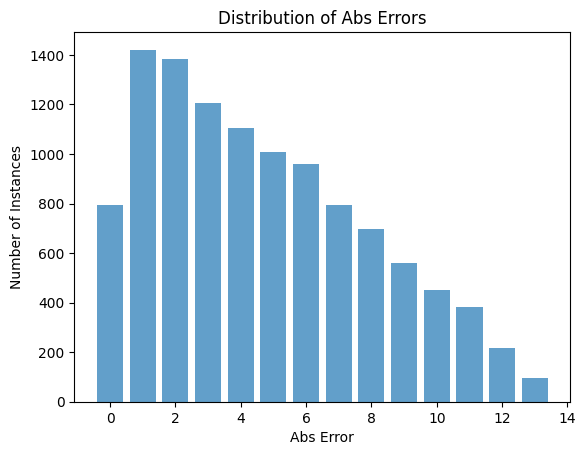

In [27]:
plot_abs_errors(valid_trues, valid_preds)

**SIMPLE LINEAR REGRESSION MODEL**

In [28]:
linear_model = LinearRegression()

linear_model.fit(X_train_scaled, y_train)

y_pred_linear = linear_model.predict(X_valid_scaled)
mae_linear = mean_absolute_error(y_valid, y_pred_linear)
mae_scores["linear_model"] = mae_linear
mae_scores["linear_model"]

2.6247998984267067

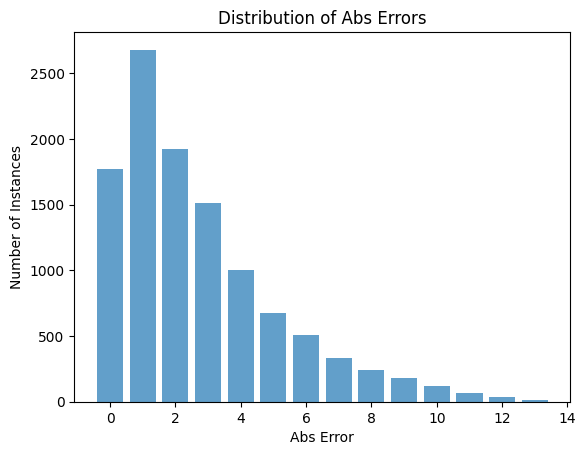

In [29]:
leagues_preds = get_league_ranks(linear_model, X_valid_scaled, y_valid)
leagues_trues = [[i for i in range(1, 15)] for _ in range(len(leagues_preds))]

valid_preds = np.concatenate(leagues_preds)
valid_trues = np.concatenate(leagues_trues)

plot_abs_errors(valid_trues, valid_preds)

**SIMPLE KNN MODEL**

In [30]:
knn_model = KNeighborsRegressor(n_neighbors=16, weights="distance")

knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_valid_scaled)
mae_knn = mean_absolute_error(y_valid, y_pred_knn)
mae_scores["knn_model"] = mae_knn
mae_scores["knn_model"]

2.5062524544005567

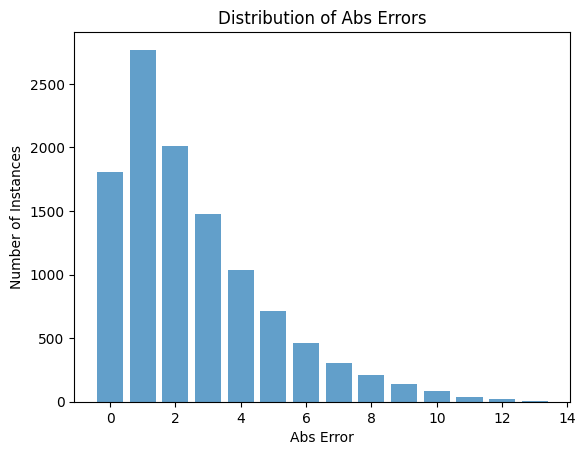

In [31]:
leagues_preds = get_league_ranks(knn_model, X_valid_scaled, y_valid)
leagues_trues = [[i for i in range(1, 15)] for _ in range(len(leagues_preds))]

valid_preds = np.concatenate(leagues_preds)
valid_trues = np.concatenate(leagues_trues)

plot_abs_errors(valid_trues, valid_preds)

**SUPORT VECTOR REGRESSOR MODEL**

In [32]:
svr_model = SVR()

svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_valid_scaled)
mae_svr = mean_absolute_error(y_valid, y_pred_svr)
mae_scores["svr_model"] = mae_svr
mae_scores["svr_model"]

2.4507883627876974

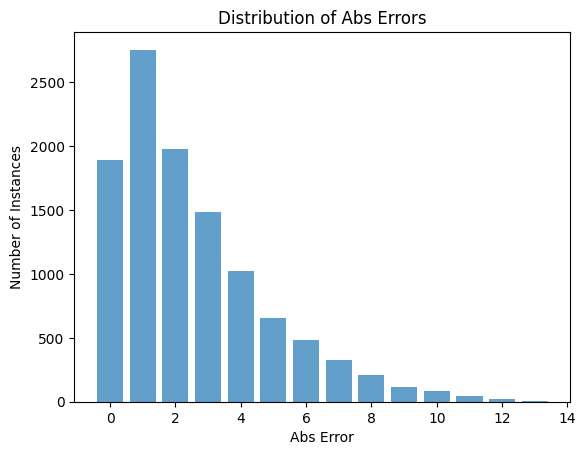

In [33]:
leagues_preds = get_league_ranks(svr_model, X_valid_scaled, y_valid)
leagues_trues = [[i for i in range(1, 15)] for _ in range(len(leagues_preds))]

valid_preds = np.concatenate(leagues_preds)
valid_trues = np.concatenate(leagues_trues)

plot_abs_errors(valid_trues, valid_preds)

**RANDOM FOREST REGRESSOR MODEL**

In [34]:
rfr_model = RandomForestRegressor()

rfr_model.fit(X_train_scaled, y_train)
y_pred_rfr = rfr_model.predict(X_valid_scaled)
mae_rfr = mean_absolute_error(y_valid, y_pred_rfr)
mae_scores["rfr_model"] = mae_rfr
mae_scores["rfr_model"]

2.4034332671121543

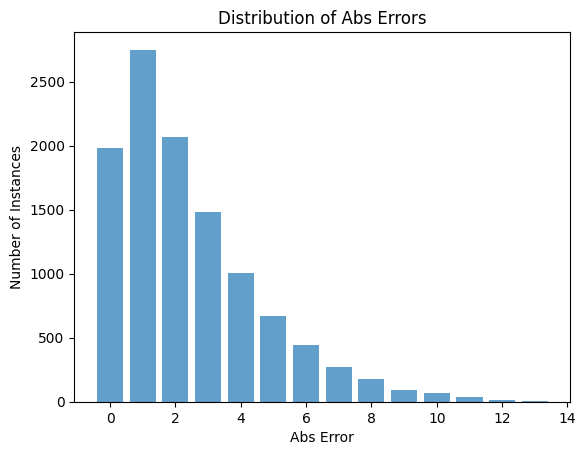

In [35]:
leagues_preds = get_league_ranks(rfr_model, X_valid_scaled, y_valid)
leagues_trues = [[i for i in range(1, 15)] for _ in range(len(leagues_preds))]

valid_preds = np.concatenate(leagues_preds)
valid_trues = np.concatenate(leagues_trues)

plot_abs_errors(valid_trues, valid_preds)

**XGBOOST REGRESSOR MODEL**

In [36]:
xgbr_model = XGBRegressor()

xgbr_model.fit(X_train_scaled, y_train)
y_pred_xgbr = xgbr_model.predict(X_valid_scaled)
mae_xgbr = mean_absolute_error(y_valid, y_pred_xgbr)
mae_scores["xgbr_model"] = mae_xgbr
mae_scores["xgbr_model"]

2.405134511780864

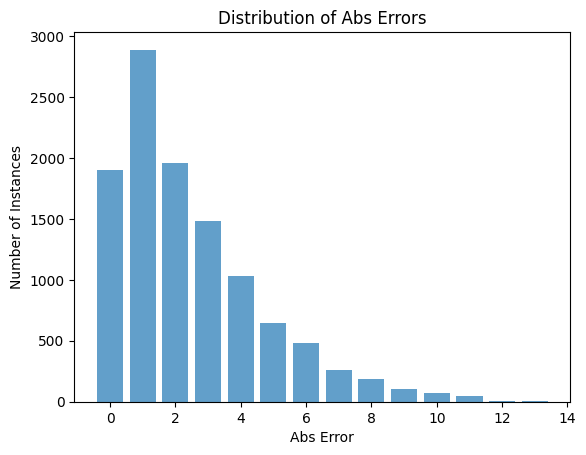

In [37]:
leagues_preds = get_league_ranks(xgbr_model, X_valid_scaled, y_valid)
leagues_trues = [[i for i in range(1, 15)] for _ in range(len(leagues_preds))]

valid_preds = np.concatenate(leagues_preds)
valid_trues = np.concatenate(leagues_trues)

plot_abs_errors(valid_trues, valid_preds)

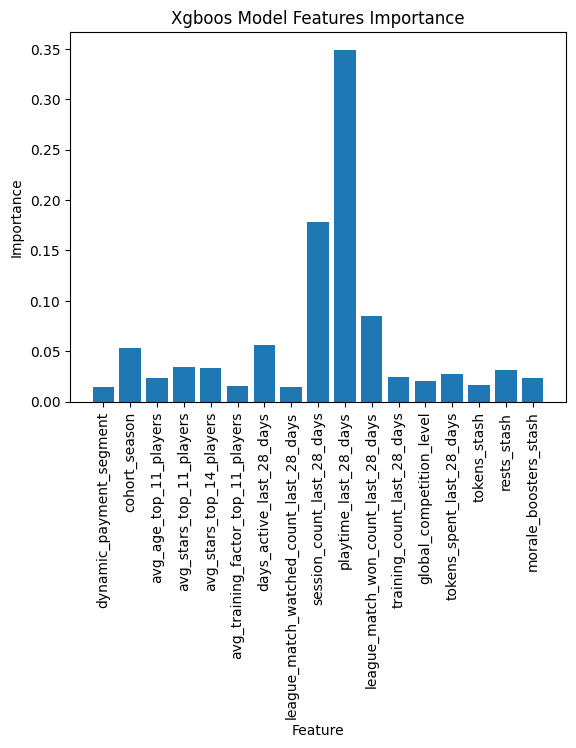

In [60]:
feature_names = X_valid.columns

plt.bar(range(len(xgbr_model.feature_importances_)), xgbr_model.feature_importances_)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(range(len(feature_names)), feature_names, rotation='vertical')
plt.title("Xgboos Model Features Importance")
plt.show()

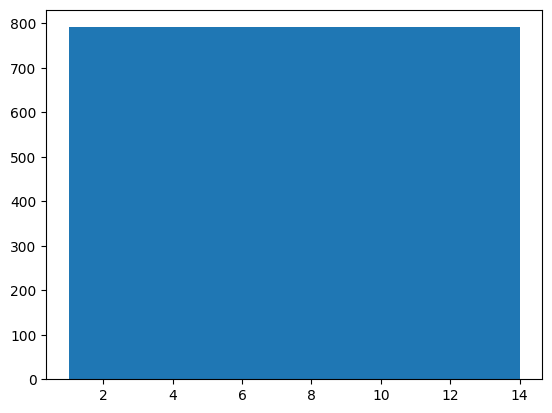

In [61]:
#Validation set has uniform distribution
plt.hist(y_valid, bins=14)
plt.show()

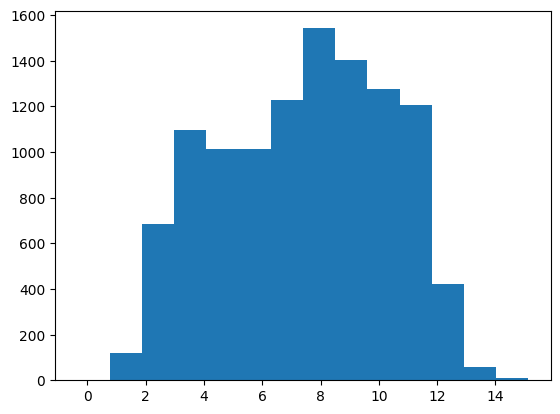

In [62]:
#predictions don't have uniform distribution 
plt.hist(y_pred_xgbr, bins=14)
plt.show()

(array([791., 791., 791., 791., 791., 791., 791., 791., 791., 791., 791.,
        791., 791., 791.]),
 array([ 1.        ,  1.92857143,  2.85714286,  3.78571429,  4.71428571,
         5.64285714,  6.57142857,  7.5       ,  8.42857143,  9.35714286,
        10.28571429, 11.21428571, 12.14285714, 13.07142857, 14.        ]),
 <BarContainer object of 14 artists>)

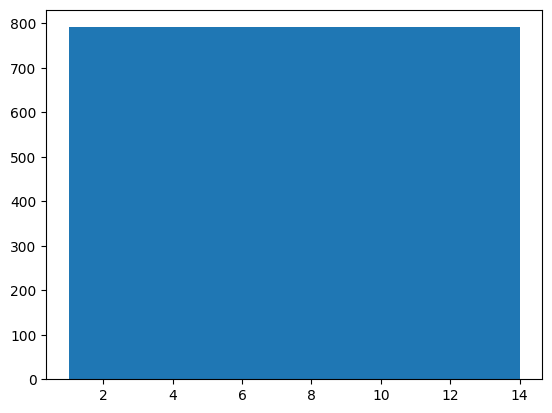

In [63]:
#after sorting the predictions and assigning new values based on their order, predictions are uniform distributed
plt.hist(valid_preds, bins=14)

In [ ]:
max(valid_trues), min(valid_trues)

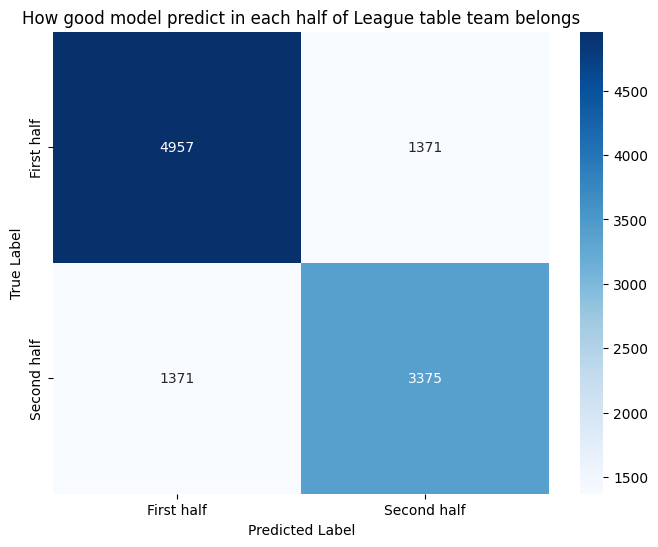

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create bins
bin_edges = [0, 8, 15]  # Bins: 0 for integers 1 to 7, 1 for integers 8 to 14
true_labels_bin = np.digitize(valid_trues, bin_edges, right=True)
predicted_labels_bin = np.digitize(valid_preds, bin_edges, right=True)

# Create the confusion matrix
conf_matrix_bin = confusion_matrix(true_labels_bin, predicted_labels_bin)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_bin, annot=True, fmt="d", cmap="Blues",
            xticklabels=['First half', 'Second half'], yticklabels=['First half', 'Second half'])
plt.title('How good model predicts is team in first or second half of League table')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


**NEURAL NETWORK MODEL**

In [64]:
nn_model = tf.keras.Sequential()

nn_model.add(tf.keras.layers.Dense(256, input_shape=(X_train_scaled.shape[1],), activation='relu'))
nn_model.add(tf.keras.layers.BatchNormalization())

nn_model.add(tf.keras.layers.Dense(256, activation='relu'))
nn_model.add(tf.keras.layers.BatchNormalization())
nn_model.add(tf.keras.layers.Dropout(0.5))

nn_model.add(tf.keras.layers.Dense(128, activation='relu'))
nn_model.add(tf.keras.layers.BatchNormalization())
nn_model.add(tf.keras.layers.Dropout(0.5))

nn_model.add(tf.keras.layers.Dense(1, activation='linear')) 

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
nn_model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               4608      
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [49]:
history = nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=14, validation_data=(X_valid_scaled, y_valid))

Epoch 1/50
3160/3160 [==============================] - 6s 2ms/step - loss: 5.1248 - mae: 5.1248 - val_loss: 2.8408 - val_mae: 2.8408
Epoch 2/50
3160/3160 [==============================] - 5s 2ms/step - loss: 3.1808 - mae: 3.1808 - val_loss: 2.6062 - val_mae: 2.6062
Epoch 3/50
3160/3160 [==============================] - 5s 2ms/step - loss: 3.0278 - mae: 3.0278 - val_loss: 2.5526 - val_mae: 2.5526
Epoch 4/50
3160/3160 [==============================] - 5s 2ms/step - loss: 2.9229 - mae: 2.9229 - val_loss: 2.5206 - val_mae: 2.5206
Epoch 5/50
3160/3160 [==============================] - 5s 2ms/step - loss: 2.8525 - mae: 2.8525 - val_loss: 2.5686 - val_mae: 2.5686
Epoch 6/50
3160/3160 [==============================] - 5s 2ms/step - loss: 2.8165 - mae: 2.8165 - val_loss: 2.5376 - val_mae: 2.5376
Epoch 7/50
3160/3160 [==============================] - 5s 2ms/step - loss: 2.7917 - mae: 2.7917 - val_loss: 2.5282 - val_mae: 2.5282
Epoch 8/50
3160/3160 [==============================] - 5s 2ms

In [50]:
y_pred_nn = nn_model.predict(X_valid_scaled).flatten()

mae_nn = mean_absolute_error(y_valid, y_pred_nn)
mae_scores["nn_model"] = mae_nn
mae_scores["nn_model"]

347/347 [==============================] - 0s 677us/step


2.458968663147819

1/1 [==============================] - 0s 12ms/step


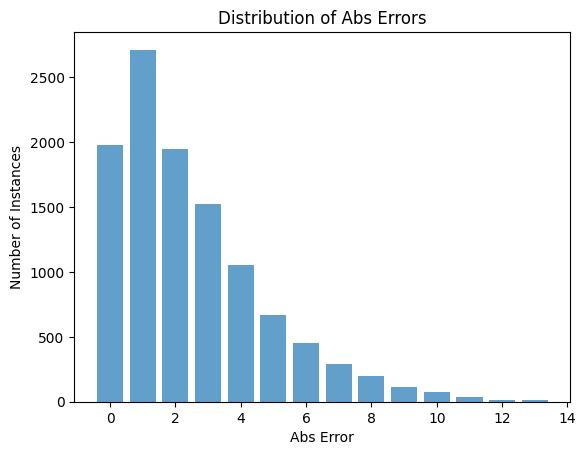

In [51]:
leagues_preds = get_league_ranks(nn_model, X_valid_scaled, y_valid)
leagues_trues = [[i for i in range(1, 15)] for _ in range(len(leagues_preds))]

valid_preds = np.concatenate(leagues_preds)
valid_trues = np.concatenate(leagues_trues)

plot_abs_errors(valid_trues, valid_preds)

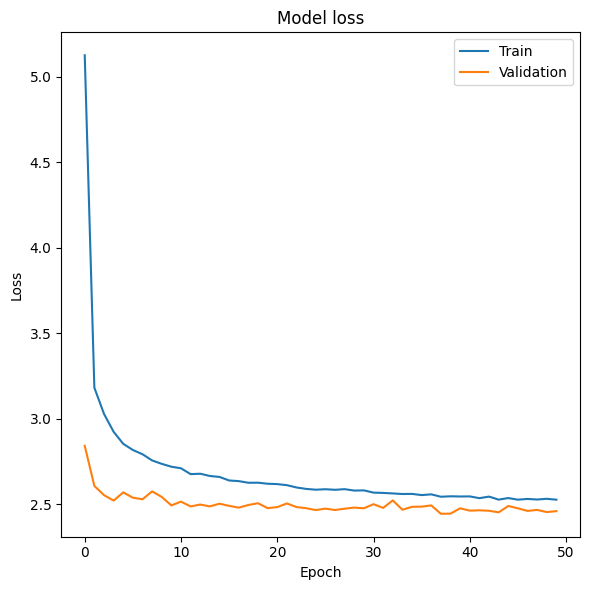

In [65]:
# Plot the learning curves
plt.figure(figsize=(6, 6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

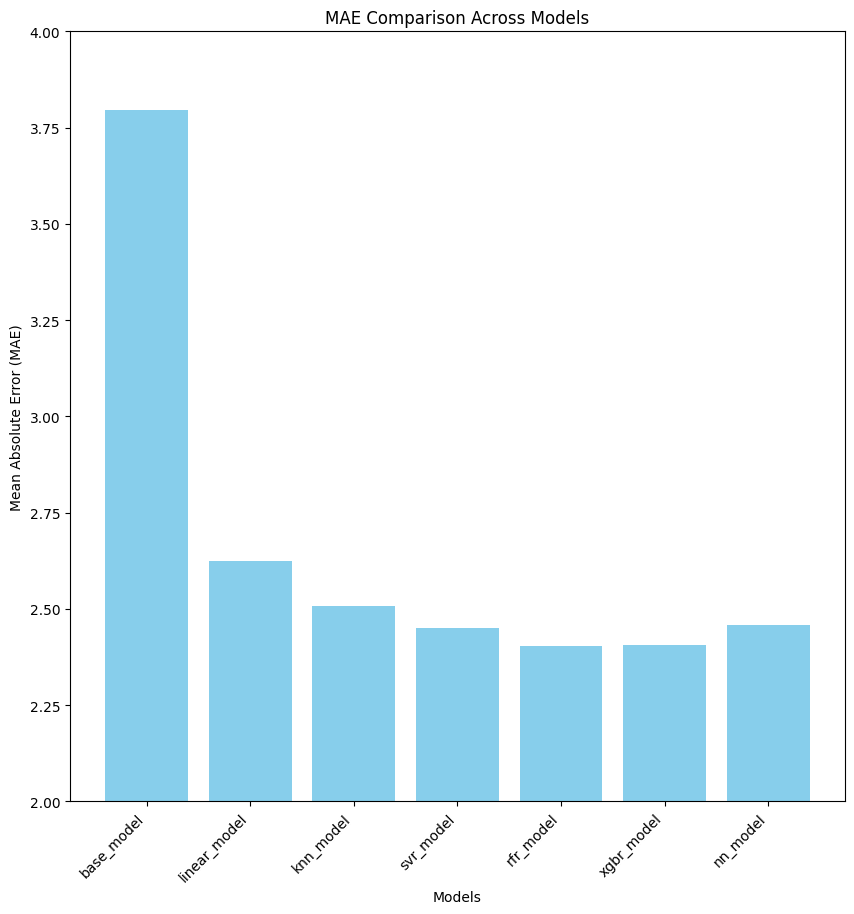

In [71]:
plt.figure(figsize=(10, 10))

plt.bar(mae_scores.keys(), mae_scores.values(), color='skyblue')
plt.xlabel('Models')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE Comparison Across Models')
plt.xticks(rotation=45, ha='right')
plt.ylim(2, 4)

plt.savefig("../initial_models_comparation.png")
plt.show()